In [1]:
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf

In [2]:
def show_image(img, is_bgr=True):
    """Function to display image
        Args: 
            img: numpy.ndarray
            is_bgr: bool. True: accepts BGR image.

        Returns: 

    """
    if is_bgr:
        display(Image.fromarray(img[:,:,::-1]))
    else:
        display(Image.fromarray(img))

In [3]:
def preprocess_image_vgg(img_path: str, img_size=224):
    """Function to prepare image for prediction (vgg16)
        Args: 
            img_path: str
            img_size: int. 224 for vgg16
            
        Returns:
            numpy.ndarray. (1, img_size, img_size, 3)

    """
    #load image from file
    x = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
    
    #preprocessing steps
    x = tf.keras.preprocessing.image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## source -> https://keras.io/examples/vision/grad_cam/
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

### prepare model

In [5]:
#init model
model = tf.keras.applications.vgg16.VGG16(weights='imagenet')

### ! TODO: update image path !

In [6]:
img_path = 'test_image_plane.jpeg'
img_size = 224

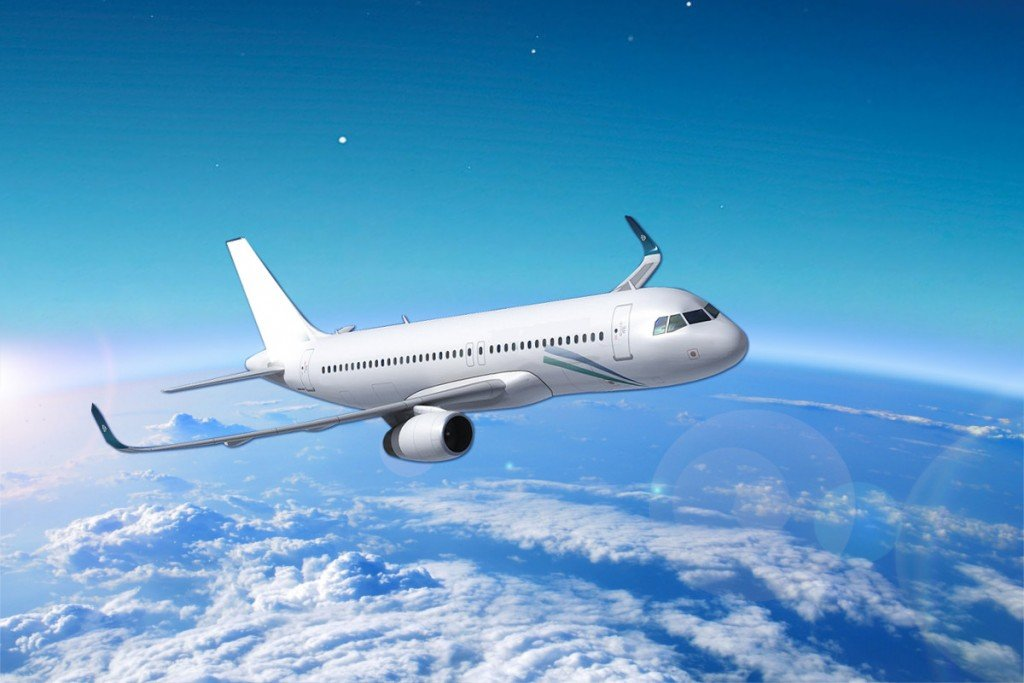

In [7]:
#show image
original_image = cv2.imread(img_path)
show_image(original_image)

### predict (single image)

In [8]:
#preprocess image
img_ = preprocess_image_vgg(img_path, img_size=img_size)

# Remove last layer's softmax
model.layers[-1].activation = None

#predict
preds = model.predict(img_)

#decode predictions
results = tf.keras.applications.vgg16.decode_predictions(preds, top=3)[0]


In [9]:
#print layer names and select the last conv layer!
for ind, layer in enumerate(model.layers):
    print(ind, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten
20 fc1
21 fc2
22 predictions


In [10]:
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_, model, "block5_conv3")

### visualize heatmap

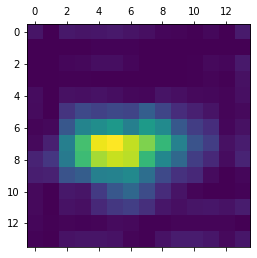

In [11]:
plt.matshow(heatmap)
plt.show()

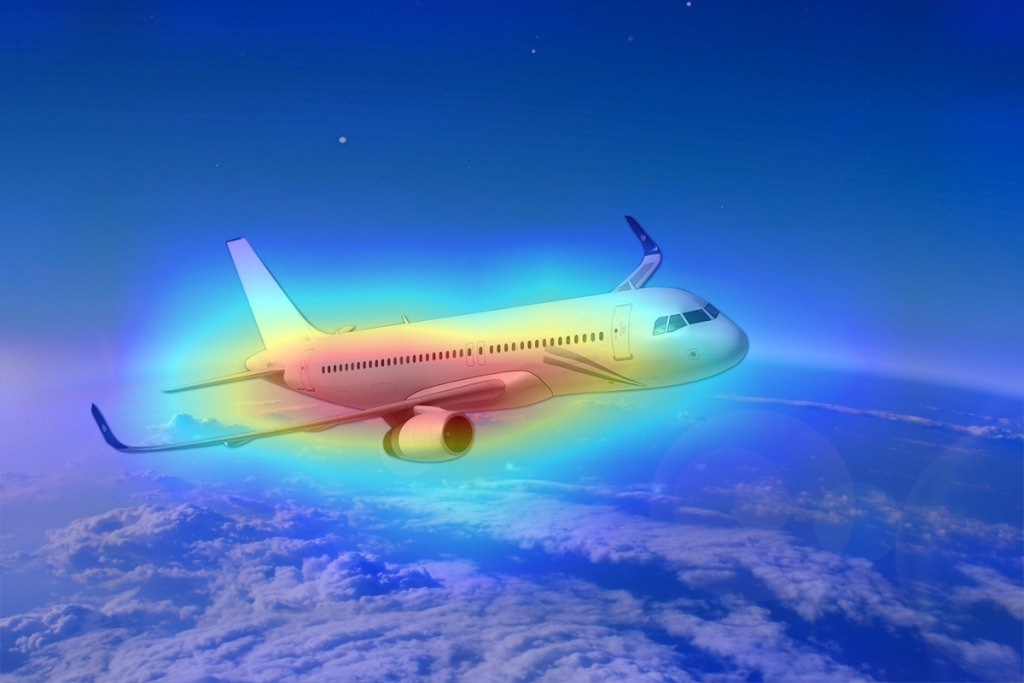

[('n02690373', 'airliner', 32.661823), ('n04266014', 'space_shuttle', 29.00204), ('n04592741', 'wing', 28.687881)]


In [12]:

#copy original image
img = original_image.copy()

#resize heatmap 
heatmap_ = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

#update pixel values : 0-1 > 0-255
heatmap_ = np.uint8(255 * heatmap_)

#combine heatmap with the original image.
heatmap_ = cv2.applyColorMap(heatmap_, cv2.COLORMAP_JET)

result_img = cv2.addWeighted(heatmap_, 0.4, img, 0.6, 0)
result_img = np.uint8(result_img)

show_image(result_img)
print(results)
